# PREP

In [116]:
!pip install pandas

     |████████████████████████████████| 12.1 MB 7.1 MB/s eta 0:00:01


In [137]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

In [138]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'

In [139]:
CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']

# IN-SAMPLE

In [166]:
RESULTS_INSAMPLE_EMPTY = load_pickle('results/202302071822_insample_empty.pickle')
THRESHOLDS = [0.1, 0.5, 0.9]

## PERFORMANCE

               precision    recall  f1-score   support

        empty       0.89      0.81      0.85       298
european_hare       0.86      0.81      0.84        63
       others       0.64      0.58      0.61       106
     red_deer       0.67      1.00      0.80         2
      red_fox       0.87      0.81      0.84       105
 red_squirrel       0.91      0.89      0.90        36
     roe_deer       0.92      0.97      0.94       905
    wild_boar       0.96      0.79      0.87        29

     accuracy                           0.89      1544
    macro avg       0.84      0.83      0.83      1544
 weighted avg       0.89      0.89      0.89      1544



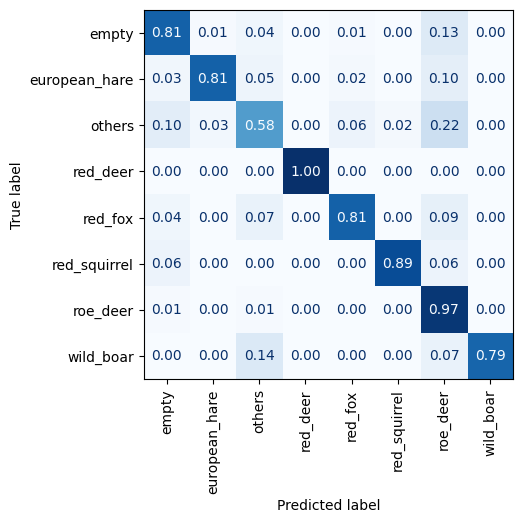

In [167]:
result_ours = RESULTS_INSAMPLE_EMPTY[THRESHOLDS[0]]
y_true = result_ours['truth_imgs']
y_pred = [np.argmax(v) for v in result_ours['preds_imgs'].values()]
report = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(label_map.keys())
)
print(report)
ConfusionMatrixDisplay.from_predictions(
    y_true=y_true, 
    y_pred=y_pred,
    normalize='true',
    values_format='.2f',
    display_labels=list(label_map.keys()),
    xticks_rotation='vertical',
    colorbar=False,
    cmap='Blues',
)

## EMPTY DETECTION ACROSS THRESHOLDS

In [168]:
rows_empty = []
rows_multiclass = []
for t in THRESHOLDS:
    result = RESULTS_INSAMPLE_EMPTY[t]
    y_true = result['truth_imgs']
    y_pred = [np.argmax(v) for v in result['preds_imgs'].values()]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(label_map.keys()),
        zero_division=0,
        output_dict=True,
    )
    rows_empty.append(
        [
            t,
            confusion_matrix(y_true, y_pred, normalize='true').diagonal()[EMPTY_CLASS],
            report['empty']['precision'],
            report['empty']['recall'],
            report['empty']['f1-score'],
        ]
    )
    rows_multiclass.append(
        [
            t, 
            report['accuracy'], 
            report['weighted avg']['precision'], 
            report['weighted avg']['recall'], 
            report['weighted avg']['f1-score']]
    )
df_ins_empty = pd.DataFrame(rows_empty, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])
df_ins_multiclass = pd.DataFrame(rows_multiclass, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])    

In [169]:
df_ins_empty, df_ins_multiclass

(   threshold       acc      prec       rec      fone
 0        0.1  0.808725  0.892593  0.808725  0.848592
 1        0.5  0.875839  0.810559  0.875839  0.841935
 2        0.9  0.916107  0.245946  0.916107  0.387784,
    threshold       acc      prec       rec      fone
 0        0.1  0.890544  0.888088  0.890544  0.888012
 1        0.5  0.838731  0.823762  0.838731  0.825851
 2        0.9  0.183938  0.276515  0.183938  0.081701)

# OUT-OF-SAMPLE

## PERFORMANCE

In [ ]:
RESULTS_OOSAMPLE_PERF = load_pickle('results/202212070005_oosample_perf.pickle')

In [ ]:
y_true = RESULTS_OOSAMPLE_PERF['truth_imgs']
y_pred = [np.argmax(v) for v in RESULTS_OOSAMPLE_PERF['preds_imgs'].values()]
report = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(label_map.keys())
)
print(report)
ConfusionMatrixDisplay.from_predictions(
    y_true=y_true, 
    y_pred=y_pred,
    normalize='true',
    values_format='.2f',
    display_labels=list(label_map.keys()),
    xticks_rotation='vertical',
    colorbar=False,
    cmap='Blues',
)

## ACTIVE LEARNING